In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ==========================
# This is to run the base model
# ==========================

import sys
sys.path.append('./..')
sys.path.append('./../..')
import pandas as pd
import yaml
from torch import FloatTensor as FT
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from utils import *
from tqdm import tqdm
import torch
from pprint import pprint
try:
    from .data_fetcher import data_fetcher
except:
    from data_fetcher import data_fetcher
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
    
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda
Current device  >>  cuda
Current device  >>  cuda


In [3]:
# ============================
#  create config for DAGMM_base
# ============================


def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'

    with open(config_file, 'r') as fh:
        config = yaml.safe_load(fh)

    data_dict, meta_data_df = data_fetcher.get_data(data_set)

    # discrete_columns : { column_name : num_categories }
    discrete_column_dims = {
        k: v for k, v in
        zip(list(meta_data_df['column']), list(meta_data_df['dimension']))
    }

    num_discrete_columns = len(discrete_column_dims)
    num_real_columns = len(data_dict['train'].columns) - num_discrete_columns
    latent_dim = config[data_set]['ae_latent_dimension']

    encoder_structure_config = {}
    encoder_structure_config['discrete_column_dims'] = discrete_column_dims
    encoder_structure_config['num_discrete'] = num_discrete_columns
    encoder_structure_config['num_real'] = num_real_columns
    encoder_structure_config['encoder_layers'] = {
        'activation': config[data_set]['encoder_layers']['activation'],
        'layer_dims': config[data_set]['encoder_layers']['layer_dims'] + [latent_dim]
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {}
    final_op_dims = num_real_columns + sum(discrete_column_dims.values())
    decoder_structure_config['discrete_column_dims'] = discrete_column_dims
    decoder_structure_config['num_discrete'] = num_discrete_columns
    decoder_structure_config['num_real'] = num_real_columns
    decoder_structure_config['decoder_layers'] = {
        'activation': config[data_set]['decoder_layers']['activation'],
        'layer_dims': [latent_dim] + config[data_set]['decoder_layers']['layer_dims'] + [final_op_dims]
    }
    decoder_structure_config['final_output_dim'] = final_op_dims

    # =====================
    # GMM
    # =====================
    gmm_input_dims = latent_dim + 2
    activation = config[data_set]['gmm']['FC_layer']['activation']
    num_components = config[data_set]['gmm']['num_components']
    FC_layer_dims = [gmm_input_dims] + config[data_set]['gmm']['FC_layer']['dims'] + [num_components]
    FC_dropout = config[data_set]['gmm']['FC_dropout']
    gmm_structure_config = {
        'num_components': num_components,
        'FC_layer_dims': FC_layer_dims,
        'FC_dropout': FC_dropout,
        'FC_activation': activation

    }
    loss_structure_config = []

    for column, dim in discrete_column_dims.items():
        loss_structure_config.append(
            {
                'dim': dim,
                'type': 'onehot'
            }
        )
    loss_structure_config.append(
        {
            'dim': num_real_columns,
            'type': 'real'
        }
    )

    return encoder_structure_config, decoder_structure_config, gmm_structure_config, loss_structure_config, latent_dim



def train(
        dagmm_obj,
        data,
        num_epochs,
        batch_size=256,
        LR=0.05
):
    optimizer = torch.optim.Adam(dagmm_obj.parameters(), lr=LR)
    dagmm_obj.train()
    log_interval = 50
    for epoch in tqdm(range(num_epochs)):
        num_batches = data.shape[0] // batch_size + 1
        epoch_losses = []
        np.random.shuffle(data)
        X = FT(data).to(DEVICE)
        lambda_energy = 0.1
        lambda_cov_diag = 0.005
        for b in range(num_batches):
            optimizer.zero_grad()
            input_data = X[b * batch_size: (b + 1) * batch_size]
            enc, dec, z, gamma = dagmm_obj(input_data)
            total_loss, sample_energy, recon_error, cov_diag = dagmm_obj.loss_function(
                input_data, dec, z, gamma,
                lambda_energy,
                lambda_cov_diag
            )

            dagmm_obj.zero_grad()
            total_loss = Variable(total_loss, requires_grad=True)
            total_loss.backward()
            epoch_losses.append(total_loss.cpu().data.numpy())
            torch.nn.utils.clip_grad_norm_(dagmm_obj.parameters(), 5)
            optimizer.step()

            loss = {}
            loss['total_loss'] = total_loss.data.item()
            loss['sample_energy'] = sample_energy.item()
            loss['recon_error'] = recon_error.item()
            loss['cov_diag'] = cov_diag.item()

            if (b + 1) % log_interval == 0:
                log = ' '
                for tag, value in loss.items():
                    log += ", {}: {:.4f}".format(tag, value)
                print(log)
        print('Epoch loss ::', np.mean(epoch_losses))
    return dagmm_obj

# =================================== #

def test(
    dagmm_obj,
    data_dict
):
    global DEVICE
    print("======================TEST MODE======================")
    dagmm_obj.eval()
    N = 0
    mu_sum = 0
    cov_sum = 0
    gamma_sum = 0

    train_X = data_dict['train'].values
    batch_size = 500
    num_batches = train_X.shape[0]//batch_size + 1
    for b in range(num_batches):
        input_data = train_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        phi, mu, cov = dagmm_obj.compute_gmm_params(z, gamma)
        batch_gamma_sum = torch.sum(gamma, dim=0)
        gamma_sum += batch_gamma_sum
        mu_sum += mu * batch_gamma_sum.unsqueeze(-1)  # keep sums of the numerator only
        cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)  # keep sums of the numerator only
        N += input_data.size(0)


    train_phi = gamma_sum / N
    train_mu = mu_sum / gamma_sum.unsqueeze(-1)
    train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

    print("N:", N)
    print("phi :", train_phi)
    print("mu : ", train_mu)
    print("covariance :", train_cov)

    # ============================ #
    # Get sample energy for test set
    # ============================ #
    test_energy = []
    train_labels = []
    train_z = []

    test_X = data_dict['test'].values
    num_batches = test_X.shape[0] // batch_size + 1
    print('Size of test ', test_X.shape[0])
    for b in range(num_batches):
        input_data = test_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        sample_energy, cov_diag = dagmm_obj.compute_energy(
            z,
            phi=train_phi,
            mu=train_mu,
            cov=train_cov,
            size_average=False
        )
        test_energy.append(sample_energy.data.cpu().numpy())
        # train_z.append(z.data.cpu().numpy())
        # train_labels.append(labels.numpy())

    test_energy = np.concatenate(test_energy, axis=0)
    print('test_energy',test_energy.shape)
    test_labels = [0 for _ in range(test_X.shape[0])]
    auc_list = []
    # ===========
    # Get per sample energy of the anomalies
    # ===========
    for key in ['anom_1','anom_2','anom_3']:
        anom_X = data_dict[key].values
        anom_labels = [1 for _ in range(anom_X.shape[0])]
        anom_energy = []
        num_batches = anom_X.shape[0] // batch_size + 1
        
        for b in range(num_batches):
            input_data = anom_X[b * batch_size: (b + 1) * batch_size]
            input_data = FT(input_data).to(DEVICE)
            enc, dec, z, gamma = dagmm_obj(input_data)
            sample_energy, cov_diag = dagmm_obj.compute_energy(
                z,
                phi=train_phi,
                mu=train_mu,
                cov=train_cov,
                size_average=False
            )
            anom_energy.append(sample_energy.data.cpu().numpy())

        anom_energy = np.concatenate(anom_energy,axis=0)
        print(anom_energy.shape)
        combined_energy = np.concatenate([anom_energy, test_energy], axis=0)
        combined_labels = np.concatenate([anom_labels, test_labels], axis=0)
        print(
            combined_energy.shape,
            combined_labels.shape
        )
        res_data = []
        for i,j in zip(combined_energy, combined_labels):
            res_data.append((i,j))
        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        #  Normalize values
        def _normalize_(val, _min,_max):
            return (val -_min)/(_max - _min)

        _max = max(combined_energy)
        _min = min(combined_energy)

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )

        res_df = res_df.sort_values(by=['score'],ascending= False)
        _max = max(res_df['score'])
        _min = min(res_df['score'])
        step = (_max - _min)/ 100

        # Vary the threshold
        thresh = _max - step
        num_anomalies = anom_X.shape[0]
        P = []
        R = []

        while thresh > _min:

            sel = res_df.loc[res_df['score'] >= thresh]
            if len(sel) == 0 :
                thresh -= step
                continue
            correct = sel.loc[sel['label'] == 1 ]
            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies
            P.append(prec)
            R.append(rec)
            thresh -= step

        from sklearn.metrics import auc
        pr_auc = auc(R, P)
        auc_list.append(pr_auc)

        print("AUC : {:0.4f} ".format(pr_auc))
        try:
            plt.figure()
            plt.title('PR Curve' + str(pr_auc))
            plt.plot(R, P)
            plt.show()
        except:
            pass
    return



    

In [4]:
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
 

In [5]:
# =================================== #
data_set = 'diabetes'
data_dict, _ = data_fetcher.get_data(data_set,True)
train_df = data_dict['train']
train_X = train_df.values

In [6]:
encoder_structure_config, decoder_structure_config, gmm_structure_config, _, latent_dim = create_config(
    data_set
)
pprint(encoder_structure_config)
pprint(decoder_structure_config)
# =================================== #

{'discrete_column_dims': {'A1Cresult': 4,
                          'acarbose': 4,
                          'admission_source_id': 17,
                          'admission_type_id': 8,
                          'age': 10,
                          'change': 2,
                          'chlorpropamide': 4,
                          'diabetesMed': 2,
                          'diag_1': 647,
                          'diag_2': 664,
                          'diag_3': 718,
                          'discharge_disposition_id': 26,
                          'gender': 3,
                          'glimepiride': 4,
                          'glipizide': 4,
                          'glipizide-metformin': 2,
                          'glyburide': 4,
                          'glyburide-metformin': 4,
                          'insulin': 4,
                          'max_glu_serum': 4,
                          'metformin': 4,
                          'metformin-pioglitazone': 2,
            

In [7]:
   
dagmm_obj = DaGMM(
    DEVICE,
    encoder_structure_config,
    decoder_structure_config,
    n_gmm=gmm_structure_config['num_components'],
    ae_latent_dim=1
)
dagmm_obj = dagmm_obj.to(DEVICE)
print(dagmm_obj)

DaGMM(
  (encoder): AE_encoder(
    (FC_z): Sequential(
      (0): Linear(in_features=2182, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): Tanh()
      (6): Linear(in_features=32, out_features=10, bias=True)
      (7): Tanh()
      (8): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (decoder): AE_decoder(
    (FC_z): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=64, bias=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=256, bias=True)
      (7): Tanh()
      (8): Linear(in_features=256, out_features=2182, bias=True)
      (9): Tanh()
    )
  )
  (estimation): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)


In [8]:
dagmm_obj = train(
    dagmm_obj,
    train_X,
    num_epochs=100,
    batch_size=256
)

  0%|          | 0/100 [00:00<?, ?it/s]

 , total_loss: 2585.6289, sample_energy: -11.8945, recon_error: 0.0238, cov_diag: 517358.8750
 , total_loss: 2676.5647, sample_energy: -11.8602, recon_error: 0.0238, cov_diag: 535545.4375


  1%|          | 1/100 [00:05<08:26,  5.11s/it]

Epoch loss :: 2511.6782
 , total_loss: 2519.9497, sample_energy: -11.8215, recon_error: 0.0238, cov_diag: 504221.6250
 , total_loss: 2641.5059, sample_energy: -11.8073, recon_error: 0.0238, cov_diag: 528532.5625


  2%|▏         | 2/100 [00:09<08:00,  4.91s/it]

Epoch loss :: 2502.9922
 , total_loss: 2535.3179, sample_energy: -11.7606, recon_error: 0.0238, cov_diag: 507294.0625
 , total_loss: 2158.5781, sample_energy: -11.6749, recon_error: 0.0238, cov_diag: 431944.4062


  3%|▎         | 3/100 [00:14<07:49,  4.84s/it]

Epoch loss :: 2511.5076
 , total_loss: 2533.1267, sample_energy: -11.7405, recon_error: 0.0238, cov_diag: 506855.3750
 , total_loss: 2546.0203, sample_energy: -11.7704, recon_error: 0.0238, cov_diag: 509434.7188


  4%|▍         | 4/100 [00:18<07:39,  4.79s/it]

Epoch loss :: 2505.655
 , total_loss: 2443.8459, sample_energy: -11.7690, recon_error: 0.0238, cov_diag: 488999.8125
 , total_loss: 2429.5723, sample_energy: -11.7251, recon_error: 0.0238, cov_diag: 486144.2188


  5%|▌         | 5/100 [00:24<07:47,  4.92s/it]

Epoch loss :: 2505.4207
 , total_loss: 2451.7192, sample_energy: -11.7357, recon_error: 0.0238, cov_diag: 490573.8125
 , total_loss: 2347.5974, sample_energy: -11.7786, recon_error: 0.0238, cov_diag: 469750.3125


  6%|▌         | 6/100 [00:29<07:43,  4.93s/it]

Epoch loss :: 2507.7195
 , total_loss: 2360.8914, sample_energy: -11.7773, recon_error: 0.0238, cov_diag: 472409.0938
 , total_loss: 2849.0798, sample_energy: -11.8719, recon_error: 0.0238, cov_diag: 570048.6250


  7%|▋         | 7/100 [00:33<07:31,  4.85s/it]

Epoch loss :: 2503.3188
 , total_loss: 2485.4202, sample_energy: -11.7576, recon_error: 0.0238, cov_diag: 497314.4375
 , total_loss: 2511.4268, sample_energy: -11.7755, recon_error: 0.0238, cov_diag: 502516.1250


  8%|▊         | 8/100 [00:37<07:04,  4.61s/it]

Epoch loss :: 2512.882
 , total_loss: 2440.9829, sample_energy: -11.7682, recon_error: 0.0238, cov_diag: 488427.1875
 , total_loss: 2312.7307, sample_energy: -11.8338, recon_error: 0.0238, cov_diag: 462778.0625


  9%|▉         | 9/100 [00:42<06:59,  4.61s/it]

Epoch loss :: 2508.4155
 , total_loss: 2570.3000, sample_energy: -11.6452, recon_error: 0.0238, cov_diag: 514288.1250
 , total_loss: 2601.7690, sample_energy: -11.8940, recon_error: 0.0238, cov_diag: 520586.9375


 10%|█         | 10/100 [00:46<06:41,  4.46s/it]

Epoch loss :: 2507.9026
 , total_loss: 2441.6155, sample_energy: -11.8404, recon_error: 0.0238, cov_diag: 488555.1250
 , total_loss: 2403.0503, sample_energy: -11.8711, recon_error: 0.0238, cov_diag: 480842.7500


 11%|█         | 11/100 [00:51<06:42,  4.52s/it]

Epoch loss :: 2509.0295
 , total_loss: 2409.2336, sample_energy: -11.7076, recon_error: 0.0238, cov_diag: 482076.1250
 , total_loss: 2377.8665, sample_energy: -11.7198, recon_error: 0.0238, cov_diag: 475802.9375


 12%|█▏        | 12/100 [00:55<06:40,  4.55s/it]

Epoch loss :: 2511.5996
 , total_loss: 2276.1943, sample_energy: -11.5939, recon_error: 0.0238, cov_diag: 455465.9688
 , total_loss: 2552.9692, sample_energy: -11.8357, recon_error: 0.0238, cov_diag: 510825.8125


 13%|█▎        | 13/100 [01:00<06:44,  4.65s/it]

Epoch loss :: 2506.457
 , total_loss: 2319.0608, sample_energy: -11.7562, recon_error: 0.0238, cov_diag: 464042.5312
 , total_loss: 2363.6731, sample_energy: -11.7744, recon_error: 0.0238, cov_diag: 472965.3438


 14%|█▍        | 14/100 [01:04<06:21,  4.43s/it]

Epoch loss :: 2515.6257
 , total_loss: 2856.2671, sample_energy: -11.9512, recon_error: 0.0238, cov_diag: 571487.6875
 , total_loss: 2289.5396, sample_energy: -11.7125, recon_error: 0.0238, cov_diag: 458137.4062


 15%|█▌        | 15/100 [01:08<06:10,  4.36s/it]

Epoch loss :: 2511.071
 , total_loss: 2569.9006, sample_energy: -11.8182, recon_error: 0.0238, cov_diag: 514211.7188
 , total_loss: 2319.8372, sample_energy: -11.7436, recon_error: 0.0238, cov_diag: 464197.5625


 16%|█▌        | 16/100 [01:12<06:01,  4.31s/it]

Epoch loss :: 2503.9648
 , total_loss: 2826.1831, sample_energy: -11.9258, recon_error: 0.0238, cov_diag: 565470.3750
 , total_loss: 2393.1921, sample_energy: -11.7519, recon_error: 0.0238, cov_diag: 478868.7188


 17%|█▋        | 17/100 [01:16<05:50,  4.22s/it]

Epoch loss :: 2517.2783
 , total_loss: 2580.8818, sample_energy: -11.7565, recon_error: 0.0238, cov_diag: 516406.7500
 , total_loss: 2339.9287, sample_energy: -11.8019, recon_error: 0.0238, cov_diag: 468217.0625


 18%|█▊        | 18/100 [01:21<05:55,  4.34s/it]

Epoch loss :: 2504.2883
 , total_loss: 2363.2810, sample_energy: -11.8989, recon_error: 0.0238, cov_diag: 472889.4375
 , total_loss: 2803.4583, sample_energy: -11.8366, recon_error: 0.0238, cov_diag: 560923.6250


 19%|█▉        | 19/100 [01:27<06:17,  4.66s/it]

Epoch loss :: 2510.6487
 , total_loss: 2529.7778, sample_energy: -11.7835, recon_error: 0.0238, cov_diag: 506186.5000
 , total_loss: 2306.2078, sample_energy: -11.6799, recon_error: 0.0238, cov_diag: 461470.4375


 20%|██        | 20/100 [01:31<06:04,  4.55s/it]

Epoch loss :: 2517.4976
 , total_loss: 2446.4673, sample_energy: -11.7603, recon_error: 0.0238, cov_diag: 489523.9375
 , total_loss: 2747.3838, sample_energy: -11.8443, recon_error: 0.0238, cov_diag: 549708.8750


 21%|██        | 21/100 [01:35<05:56,  4.52s/it]

Epoch loss :: 2510.5078
 , total_loss: 2215.0142, sample_energy: -11.6365, recon_error: 0.0238, cov_diag: 443230.8125
 , total_loss: 2598.2466, sample_energy: -11.7592, recon_error: 0.0238, cov_diag: 519879.7500


 22%|██▏       | 22/100 [01:40<05:46,  4.44s/it]

Epoch loss :: 2506.1553
 , total_loss: 2642.4734, sample_energy: -11.8912, recon_error: 0.0238, cov_diag: 528727.7500
 , total_loss: 2499.3523, sample_energy: -11.6056, recon_error: 0.0238, cov_diag: 500097.8125


 23%|██▎       | 23/100 [01:44<05:46,  4.51s/it]

Epoch loss :: 2509.082
 , total_loss: 2430.1040, sample_energy: -11.7246, recon_error: 0.0238, cov_diag: 486250.5625
 , total_loss: 2424.6995, sample_energy: -11.9121, recon_error: 0.0238, cov_diag: 485173.4062


 24%|██▍       | 24/100 [01:49<05:44,  4.54s/it]

Epoch loss :: 2515.822
 , total_loss: 2520.6321, sample_energy: -11.8371, recon_error: 0.0238, cov_diag: 504358.4062
 , total_loss: 2656.8201, sample_energy: -11.8901, recon_error: 0.0238, cov_diag: 531597.0625


 25%|██▌       | 25/100 [01:53<05:41,  4.55s/it]

Epoch loss :: 2516.0579
 , total_loss: 2501.2471, sample_energy: -11.7285, recon_error: 0.0238, cov_diag: 500479.1875
 , total_loss: 2761.3015, sample_energy: -12.0212, recon_error: 0.0238, cov_diag: 552496.0000


 26%|██▌       | 26/100 [01:58<05:47,  4.70s/it]

Epoch loss :: 2503.044
 , total_loss: 2559.3608, sample_energy: -11.8049, recon_error: 0.0238, cov_diag: 512103.5312
 , total_loss: 2700.3853, sample_energy: -11.7796, recon_error: 0.0238, cov_diag: 540307.8750


 27%|██▋       | 27/100 [02:04<05:55,  4.88s/it]

Epoch loss :: 2509.9712
 , total_loss: 2567.7500, sample_energy: -11.8932, recon_error: 0.0238, cov_diag: 513783.0938
 , total_loss: 2242.3313, sample_energy: -11.7441, recon_error: 0.0238, cov_diag: 448696.3750


 28%|██▊       | 28/100 [02:08<05:45,  4.79s/it]

Epoch loss :: 2508.1643
 , total_loss: 2796.0320, sample_energy: -11.9190, recon_error: 0.0238, cov_diag: 559440.0000
 , total_loss: 2593.8962, sample_energy: -11.7920, recon_error: 0.0238, cov_diag: 519010.3125


 29%|██▉       | 29/100 [02:14<05:52,  4.97s/it]

Epoch loss :: 2508.706
 , total_loss: 2406.0461, sample_energy: -11.7972, recon_error: 0.0238, cov_diag: 481440.4375
 , total_loss: 2453.0154, sample_energy: -11.8800, recon_error: 0.0238, cov_diag: 490835.9062


 30%|███       | 30/100 [02:19<05:55,  5.08s/it]

Epoch loss :: 2512.7764
 , total_loss: 2370.9756, sample_energy: -11.8714, recon_error: 0.0238, cov_diag: 474427.8125
 , total_loss: 2868.7524, sample_energy: -11.9584, recon_error: 0.0238, cov_diag: 573984.9375


 31%|███       | 31/100 [02:24<05:50,  5.08s/it]

Epoch loss :: 2504.2554
 , total_loss: 2596.9836, sample_energy: -11.7477, recon_error: 0.0238, cov_diag: 519626.9062
 , total_loss: 3007.8247, sample_energy: -12.0306, recon_error: 0.0238, cov_diag: 601800.8125


 32%|███▏      | 32/100 [02:29<05:36,  4.95s/it]

Epoch loss :: 2511.6821
 , total_loss: 2396.1633, sample_energy: -11.8399, recon_error: 0.0238, cov_diag: 479464.7188
 , total_loss: 2274.7234, sample_energy: -11.6522, recon_error: 0.0238, cov_diag: 455172.9375


 33%|███▎      | 33/100 [02:33<05:22,  4.82s/it]

Epoch loss :: 2506.4534
 , total_loss: 2300.5913, sample_energy: -11.7710, recon_error: 0.0238, cov_diag: 460348.9375
 , total_loss: 2547.0984, sample_energy: -11.7573, recon_error: 0.0238, cov_diag: 509650.0625


 34%|███▍      | 34/100 [02:38<05:25,  4.93s/it]

Epoch loss :: 2516.9785
 , total_loss: 2344.1799, sample_energy: -11.9109, recon_error: 0.0237, cov_diag: 469069.4375
 , total_loss: 2544.6255, sample_energy: -11.8177, recon_error: 0.0238, cov_diag: 509156.7188


 35%|███▌      | 35/100 [02:43<05:11,  4.80s/it]

Epoch loss :: 2515.9324
 , total_loss: 2430.5308, sample_energy: -11.7949, recon_error: 0.0238, cov_diag: 486337.3125
 , total_loss: 2570.7305, sample_energy: -11.9695, recon_error: 0.0238, cov_diag: 514380.7188


 36%|███▌      | 36/100 [02:47<05:01,  4.71s/it]

Epoch loss :: 2510.0195
 , total_loss: 2579.7039, sample_energy: -11.8277, recon_error: 0.0238, cov_diag: 516172.5938
 , total_loss: 2468.4768, sample_energy: -11.8759, recon_error: 0.0238, cov_diag: 493928.1562


 37%|███▋      | 37/100 [02:52<04:44,  4.52s/it]

Epoch loss :: 2511.0383
 , total_loss: 2297.7874, sample_energy: -11.6594, recon_error: 0.0238, cov_diag: 459785.8750
 , total_loss: 2663.2832, sample_energy: -11.8358, recon_error: 0.0238, cov_diag: 532888.5625


 38%|███▊      | 38/100 [02:57<04:55,  4.77s/it]

Epoch loss :: 2509.72
 , total_loss: 2742.9343, sample_energy: -11.8776, recon_error: 0.0238, cov_diag: 548819.6250
 , total_loss: 2521.5972, sample_energy: -11.8720, recon_error: 0.0238, cov_diag: 504552.1250


 39%|███▉      | 39/100 [03:01<04:41,  4.62s/it]

Epoch loss :: 2508.8953
 , total_loss: 2522.8132, sample_energy: -11.8931, recon_error: 0.0238, cov_diag: 504795.7812
 , total_loss: 2790.7432, sample_energy: -11.9617, recon_error: 0.0238, cov_diag: 558383.1250


 40%|████      | 40/100 [03:05<04:30,  4.50s/it]

Epoch loss :: 2509.9285
 , total_loss: 2160.2930, sample_energy: -11.5375, recon_error: 0.0238, cov_diag: 432284.5938
 , total_loss: 2491.1357, sample_energy: -11.8313, recon_error: 0.0238, cov_diag: 498459.0625


 41%|████      | 41/100 [03:09<04:17,  4.37s/it]

Epoch loss :: 2507.9028
 , total_loss: 2805.4128, sample_energy: -11.9023, recon_error: 0.0238, cov_diag: 561315.8750
 , total_loss: 2424.1548, sample_energy: -11.8414, recon_error: 0.0238, cov_diag: 485063.0625


 42%|████▏     | 42/100 [03:14<04:19,  4.48s/it]

Epoch loss :: 2515.8306
 , total_loss: 2834.2847, sample_energy: -11.6990, recon_error: 0.0238, cov_diag: 567086.1250
 , total_loss: 2503.1951, sample_energy: -11.7303, recon_error: 0.0238, cov_diag: 500868.8750


 43%|████▎     | 43/100 [03:20<04:31,  4.77s/it]

Epoch loss :: 2505.448
 , total_loss: 2304.9368, sample_energy: -11.6669, recon_error: 0.0238, cov_diag: 461215.9375
 , total_loss: 2210.9456, sample_energy: -11.7293, recon_error: 0.0238, cov_diag: 442418.9375


 44%|████▍     | 44/100 [03:24<04:24,  4.72s/it]

Epoch loss :: 2518.588
 , total_loss: 2434.2363, sample_energy: -11.7740, recon_error: 0.0238, cov_diag: 487078.0000
 , total_loss: 2186.3069, sample_energy: -11.7113, recon_error: 0.0238, cov_diag: 437490.8438


 45%|████▌     | 45/100 [03:29<04:19,  4.72s/it]

Epoch loss :: 2508.243
 , total_loss: 2426.8735, sample_energy: -11.8806, recon_error: 0.0238, cov_diag: 485607.5938
 , total_loss: 2975.2231, sample_energy: -12.0013, recon_error: 0.0238, cov_diag: 595279.8750


 46%|████▌     | 46/100 [03:33<04:08,  4.61s/it]

Epoch loss :: 2512.6743
 , total_loss: 2385.6992, sample_energy: -11.7945, recon_error: 0.0238, cov_diag: 477371.0000
 , total_loss: 3085.5212, sample_energy: -12.0995, recon_error: 0.0238, cov_diag: 617341.5000


 47%|████▋     | 47/100 [03:38<03:58,  4.50s/it]

Epoch loss :: 2510.7383
 , total_loss: 2561.2039, sample_energy: -11.7765, recon_error: 0.0238, cov_diag: 512471.5312
 , total_loss: 2498.5081, sample_energy: -11.7346, recon_error: 0.0238, cov_diag: 499931.5312


 48%|████▊     | 48/100 [03:42<03:57,  4.56s/it]

Epoch loss :: 2508.62
 , total_loss: 2691.9070, sample_energy: -11.8428, recon_error: 0.0238, cov_diag: 538613.5000
 , total_loss: 2406.0742, sample_energy: -11.6996, recon_error: 0.0238, cov_diag: 481444.0938


 49%|████▉     | 49/100 [03:47<03:49,  4.50s/it]

Epoch loss :: 2507.7256
 , total_loss: 2559.8264, sample_energy: -11.9194, recon_error: 0.0238, cov_diag: 512198.9375
 , total_loss: 2445.9861, sample_energy: -11.6637, recon_error: 0.0238, cov_diag: 489425.7500


 50%|█████     | 50/100 [03:51<03:45,  4.51s/it]

Epoch loss :: 2510.6812
 , total_loss: 2148.8396, sample_energy: -11.6129, recon_error: 0.0238, cov_diag: 429995.4375
 , total_loss: 2345.0356, sample_energy: -11.7618, recon_error: 0.0238, cov_diag: 469237.6250


 51%|█████     | 51/100 [03:56<03:43,  4.56s/it]

Epoch loss :: 2512.9868
 , total_loss: 2283.0732, sample_energy: -11.7259, recon_error: 0.0238, cov_diag: 456844.4062
 , total_loss: 2587.0549, sample_energy: -11.8364, recon_error: 0.0238, cov_diag: 517643.0000


 52%|█████▏    | 52/100 [04:00<03:38,  4.56s/it]

Epoch loss :: 2503.673
 , total_loss: 2361.7549, sample_energy: -11.7054, recon_error: 0.0238, cov_diag: 472580.3125
 , total_loss: 2664.1196, sample_energy: -11.9553, recon_error: 0.0238, cov_diag: 533058.2500


 53%|█████▎    | 53/100 [04:05<03:28,  4.44s/it]

Epoch loss :: 2514.8286
 , total_loss: 2642.7109, sample_energy: -11.9377, recon_error: 0.0238, cov_diag: 528776.1875
 , total_loss: 2524.7927, sample_energy: -11.8336, recon_error: 0.0238, cov_diag: 505190.4688


 54%|█████▍    | 54/100 [04:09<03:21,  4.38s/it]

Epoch loss :: 2517.9705
 , total_loss: 2464.1165, sample_energy: -11.8036, recon_error: 0.0238, cov_diag: 493054.6250
 , total_loss: 2530.3247, sample_energy: -11.7907, recon_error: 0.0238, cov_diag: 506296.0312


 55%|█████▌    | 55/100 [04:13<03:20,  4.46s/it]

Epoch loss :: 2504.3472
 , total_loss: 2463.2488, sample_energy: -11.8356, recon_error: 0.0238, cov_diag: 492881.6875
 , total_loss: 2575.7014, sample_energy: -11.7837, recon_error: 0.0238, cov_diag: 515371.1875


 56%|█████▌    | 56/100 [04:18<03:15,  4.45s/it]

Epoch loss :: 2507.1882
 , total_loss: 2631.1465, sample_energy: -11.8314, recon_error: 0.0238, cov_diag: 526461.1875
 , total_loss: 2489.9883, sample_energy: -11.6714, recon_error: 0.0238, cov_diag: 498226.3125


 57%|█████▋    | 57/100 [04:22<03:08,  4.39s/it]

Epoch loss :: 2507.3716
 , total_loss: 2319.8193, sample_energy: -11.6862, recon_error: 0.0238, cov_diag: 464192.8438
 , total_loss: 2452.6724, sample_energy: -11.8732, recon_error: 0.0238, cov_diag: 490767.1875


 58%|█████▊    | 58/100 [04:27<03:04,  4.40s/it]

Epoch loss :: 2506.7078
 , total_loss: 2415.6650, sample_energy: -11.7619, recon_error: 0.0238, cov_diag: 483363.4688
 , total_loss: 2418.3918, sample_energy: -11.7542, recon_error: 0.0238, cov_diag: 483908.6875


 59%|█████▉    | 59/100 [04:31<03:06,  4.54s/it]

Epoch loss :: 2506.4836
 , total_loss: 2555.5413, sample_energy: -11.8450, recon_error: 0.0238, cov_diag: 511340.3750
 , total_loss: 2763.7678, sample_energy: -11.9838, recon_error: 0.0238, cov_diag: 552988.5000


 60%|██████    | 60/100 [04:36<02:57,  4.43s/it]

Epoch loss :: 2512.8481
 , total_loss: 2898.0679, sample_energy: -11.8633, recon_error: 0.0238, cov_diag: 579846.1250
 , total_loss: 2553.6240, sample_energy: -11.8568, recon_error: 0.0238, cov_diag: 510957.1875


 61%|██████    | 61/100 [04:41<03:02,  4.67s/it]

Epoch loss :: 2506.301
 , total_loss: 2446.8284, sample_energy: -11.8287, recon_error: 0.0238, cov_diag: 489597.5312
 , total_loss: 2854.0728, sample_energy: -11.8771, recon_error: 0.0238, cov_diag: 571047.3125


 62%|██████▏   | 62/100 [04:45<02:57,  4.66s/it]

Epoch loss :: 2513.6978
 , total_loss: 2216.3569, sample_energy: -11.7517, recon_error: 0.0238, cov_diag: 443501.6875
 , total_loss: 2603.9531, sample_energy: -11.8960, recon_error: 0.0238, cov_diag: 521023.8125


 63%|██████▎   | 63/100 [04:50<02:46,  4.51s/it]

Epoch loss :: 2510.0776
 , total_loss: 2553.9534, sample_energy: -11.7504, recon_error: 0.0238, cov_diag: 511020.9688
 , total_loss: 2641.4868, sample_energy: -11.8661, recon_error: 0.0238, cov_diag: 528529.9375


 64%|██████▍   | 64/100 [04:54<02:40,  4.45s/it]

Epoch loss :: 2508.468
 , total_loss: 2121.3511, sample_energy: -11.5920, recon_error: 0.0238, cov_diag: 424497.2812
 , total_loss: 2677.6604, sample_energy: -11.7593, recon_error: 0.0238, cov_diag: 535762.5000


 65%|██████▌   | 65/100 [04:58<02:31,  4.34s/it]

Epoch loss :: 2506.3586
 , total_loss: 2595.6877, sample_energy: -11.9818, recon_error: 0.0238, cov_diag: 519372.4375
 , total_loss: 2237.3860, sample_energy: -11.8414, recon_error: 0.0238, cov_diag: 447709.2812


 66%|██████▌   | 66/100 [05:02<02:29,  4.39s/it]

Epoch loss :: 2514.243
 , total_loss: 2320.5146, sample_energy: -11.7034, recon_error: 0.0238, cov_diag: 464332.2500
 , total_loss: 2696.0024, sample_energy: -11.9756, recon_error: 0.0238, cov_diag: 539435.2500


 67%|██████▋   | 67/100 [05:07<02:28,  4.51s/it]

Epoch loss :: 2513.4597
 , total_loss: 2610.3289, sample_energy: -11.6896, recon_error: 0.0238, cov_diag: 522294.7812
 , total_loss: 2343.5601, sample_energy: -11.7675, recon_error: 0.0238, cov_diag: 468942.5938


 68%|██████▊   | 68/100 [05:12<02:23,  4.48s/it]

Epoch loss :: 2510.1313
 , total_loss: 2675.2986, sample_energy: -11.8146, recon_error: 0.0238, cov_diag: 535291.2500
 , total_loss: 2349.2019, sample_energy: -11.7258, recon_error: 0.0238, cov_diag: 470070.1250


 69%|██████▉   | 69/100 [05:16<02:15,  4.39s/it]

Epoch loss :: 2510.9543
 , total_loss: 2380.3513, sample_energy: -11.7995, recon_error: 0.0238, cov_diag: 476301.5000
 , total_loss: 2363.4978, sample_energy: -11.7713, recon_error: 0.0238, cov_diag: 472930.2188


 70%|███████   | 70/100 [05:20<02:11,  4.39s/it]

Epoch loss :: 2507.5742
 , total_loss: 2517.9258, sample_energy: -11.7557, recon_error: 0.0238, cov_diag: 503815.5312
 , total_loss: 2526.9973, sample_energy: -11.7936, recon_error: 0.0238, cov_diag: 505630.5625


 71%|███████   | 71/100 [05:25<02:09,  4.47s/it]

Epoch loss :: 2510.1445
 , total_loss: 2391.7014, sample_energy: -11.7891, recon_error: 0.0238, cov_diag: 478571.3125
 , total_loss: 3037.9646, sample_energy: -11.8800, recon_error: 0.0238, cov_diag: 607825.8125


 72%|███████▏  | 72/100 [05:29<02:03,  4.41s/it]

Epoch loss :: 2512.9321
 , total_loss: 2476.6348, sample_energy: -11.8137, recon_error: 0.0238, cov_diag: 495558.5000
 , total_loss: 2256.4468, sample_energy: -11.6118, recon_error: 0.0238, cov_diag: 451516.8750


 73%|███████▎  | 73/100 [05:34<01:59,  4.41s/it]

Epoch loss :: 2510.7852
 , total_loss: 2674.6082, sample_energy: -11.8695, recon_error: 0.0238, cov_diag: 535154.2500
 , total_loss: 2458.8030, sample_energy: -11.7183, recon_error: 0.0238, cov_diag: 491990.1875


 74%|███████▍  | 74/100 [05:39<01:58,  4.57s/it]

Epoch loss :: 2507.084
 , total_loss: 2916.3005, sample_energy: -11.9163, recon_error: 0.0238, cov_diag: 583493.6875
 , total_loss: 2358.7300, sample_energy: -11.7058, recon_error: 0.0238, cov_diag: 471975.3438


 75%|███████▌  | 75/100 [05:43<01:52,  4.52s/it]

Epoch loss :: 2507.791
 , total_loss: 2460.1365, sample_energy: -11.8032, recon_error: 0.0238, cov_diag: 492258.6250
 , total_loss: 2634.5869, sample_energy: -11.8652, recon_error: 0.0238, cov_diag: 527149.9375


 76%|███████▌  | 76/100 [05:47<01:48,  4.52s/it]

Epoch loss :: 2510.5098
 , total_loss: 2307.9480, sample_energy: -11.8110, recon_error: 0.0238, cov_diag: 461821.0625
 , total_loss: 2123.8477, sample_energy: -11.6022, recon_error: 0.0238, cov_diag: 424996.8125


 77%|███████▋  | 77/100 [05:52<01:40,  4.39s/it]

Epoch loss :: 2512.0618
 , total_loss: 2522.0720, sample_energy: -11.8234, recon_error: 0.0238, cov_diag: 504646.1250
 , total_loss: 2574.5940, sample_energy: -11.8364, recon_error: 0.0238, cov_diag: 515150.8125


 78%|███████▊  | 78/100 [05:56<01:34,  4.31s/it]

Epoch loss :: 2507.5586
 , total_loss: 2350.8892, sample_energy: -11.8716, recon_error: 0.0238, cov_diag: 470410.5312
 , total_loss: 2732.1289, sample_energy: -11.9352, recon_error: 0.0238, cov_diag: 546659.7500


 79%|███████▉  | 79/100 [06:00<01:31,  4.36s/it]

Epoch loss :: 2505.4827
 , total_loss: 2163.1975, sample_energy: -11.6580, recon_error: 0.0238, cov_diag: 432867.8750
 , total_loss: 2513.9602, sample_energy: -11.6940, recon_error: 0.0238, cov_diag: 503021.1562


 80%|████████  | 80/100 [06:05<01:28,  4.42s/it]

Epoch loss :: 2512.9658
 , total_loss: 2299.0073, sample_energy: -11.8213, recon_error: 0.0238, cov_diag: 460033.1875
 , total_loss: 2465.0808, sample_energy: -11.7780, recon_error: 0.0238, cov_diag: 493246.9688


 81%|████████  | 81/100 [06:09<01:21,  4.30s/it]

Epoch loss :: 2509.0928
 , total_loss: 2120.7737, sample_energy: -11.6503, recon_error: 0.0238, cov_diag: 424383.0312
 , total_loss: 2327.4163, sample_energy: -11.6853, recon_error: 0.0238, cov_diag: 465712.2188


 82%|████████▏ | 82/100 [06:13<01:16,  4.24s/it]

Epoch loss :: 2507.3103
 , total_loss: 2536.8958, sample_energy: -11.9703, recon_error: 0.0238, cov_diag: 507613.8125
 , total_loss: 2242.1084, sample_energy: -11.7302, recon_error: 0.0238, cov_diag: 448651.5000


 83%|████████▎ | 83/100 [06:18<01:14,  4.37s/it]

Epoch loss :: 2516.9243
 , total_loss: 2505.1479, sample_energy: -11.8228, recon_error: 0.0238, cov_diag: 501261.2812
 , total_loss: 2359.3384, sample_energy: -11.6135, recon_error: 0.0238, cov_diag: 472095.1875


 84%|████████▍ | 84/100 [06:22<01:08,  4.30s/it]

Epoch loss :: 2503.4197
 , total_loss: 2322.8840, sample_energy: -11.9668, recon_error: 0.0238, cov_diag: 464811.4062
 , total_loss: 2660.5706, sample_energy: -11.8861, recon_error: 0.0238, cov_diag: 532347.0625


 85%|████████▌ | 85/100 [06:27<01:07,  4.48s/it]

Epoch loss :: 2510.1946
 , total_loss: 2409.0051, sample_energy: -11.7106, recon_error: 0.0238, cov_diag: 482030.5000
 , total_loss: 2525.4570, sample_energy: -11.8832, recon_error: 0.0238, cov_diag: 505324.3125


 86%|████████▌ | 86/100 [06:31<01:00,  4.35s/it]

Epoch loss :: 2513.9636
 , total_loss: 2676.1572, sample_energy: -11.8561, recon_error: 0.0238, cov_diag: 535463.8125
 , total_loss: 2369.3428, sample_energy: -11.7108, recon_error: 0.0238, cov_diag: 474098.0000


 87%|████████▋ | 87/100 [06:35<00:58,  4.49s/it]

Epoch loss :: 2511.1985
 , total_loss: 2370.3342, sample_energy: -11.7955, recon_error: 0.0238, cov_diag: 474298.0000
 , total_loss: 2351.3115, sample_energy: -11.7105, recon_error: 0.0238, cov_diag: 470491.7500


 88%|████████▊ | 88/100 [06:40<00:53,  4.48s/it]

Epoch loss :: 2508.6511
 , total_loss: 2310.6501, sample_energy: -11.8341, recon_error: 0.0238, cov_diag: 462361.9688
 , total_loss: 2209.1396, sample_energy: -11.7546, recon_error: 0.0238, cov_diag: 442058.2500


 89%|████████▉ | 89/100 [06:44<00:48,  4.44s/it]

Epoch loss :: 2507.1199
 , total_loss: 2417.8420, sample_energy: -11.8123, recon_error: 0.0238, cov_diag: 483799.9062
 , total_loss: 2595.4700, sample_energy: -11.8541, recon_error: 0.0238, cov_diag: 519326.3125


 90%|█████████ | 90/100 [06:49<00:44,  4.50s/it]

Epoch loss :: 2513.7183
 , total_loss: 2559.9712, sample_energy: -11.8427, recon_error: 0.0238, cov_diag: 512226.3125
 , total_loss: 2713.4590, sample_energy: -11.7203, recon_error: 0.0239, cov_diag: 542921.4375


 91%|█████████ | 91/100 [06:53<00:39,  4.41s/it]

Epoch loss :: 2507.7146
 , total_loss: 2441.5725, sample_energy: -11.9291, recon_error: 0.0238, cov_diag: 488548.3438
 , total_loss: 2317.5054, sample_energy: -11.7506, recon_error: 0.0238, cov_diag: 463731.3438


 92%|█████████▏| 92/100 [06:58<00:36,  4.53s/it]

Epoch loss :: 2508.823
 , total_loss: 2592.1831, sample_energy: -11.7987, recon_error: 0.0238, cov_diag: 518667.8125
 , total_loss: 2469.4163, sample_energy: -11.7495, recon_error: 0.0238, cov_diag: 494113.5000


 93%|█████████▎| 93/100 [07:03<00:32,  4.62s/it]

Epoch loss :: 2512.6777
 , total_loss: 2246.7625, sample_energy: -11.7639, recon_error: 0.0238, cov_diag: 449583.0312
 , total_loss: 2486.9495, sample_energy: -11.9241, recon_error: 0.0238, cov_diag: 497623.6250


 94%|█████████▍| 94/100 [07:07<00:27,  4.50s/it]

Epoch loss :: 2521.6343
 , total_loss: 2361.2776, sample_energy: -11.7164, recon_error: 0.0238, cov_diag: 472485.0625
 , total_loss: 2571.8367, sample_energy: -11.8773, recon_error: 0.0238, cov_diag: 514600.1250


 95%|█████████▌| 95/100 [07:12<00:23,  4.69s/it]

Epoch loss :: 2511.7007
 , total_loss: 2349.5537, sample_energy: -11.6323, recon_error: 0.0238, cov_diag: 470138.6250
 , total_loss: 2281.7295, sample_energy: -11.6528, recon_error: 0.0238, cov_diag: 456574.2500


 96%|█████████▌| 96/100 [07:17<00:18,  4.69s/it]

Epoch loss :: 2507.587
 , total_loss: 2158.1299, sample_energy: -11.6989, recon_error: 0.0238, cov_diag: 431855.1875
 , total_loss: 2294.7395, sample_energy: -11.7307, recon_error: 0.0238, cov_diag: 459177.7500


 97%|█████████▋| 97/100 [07:21<00:13,  4.58s/it]

Epoch loss :: 2514.8818
 , total_loss: 2474.9368, sample_energy: -11.5914, recon_error: 0.0238, cov_diag: 495214.4375
 , total_loss: 2332.9971, sample_energy: -11.8116, recon_error: 0.0238, cov_diag: 466830.9375


 98%|█████████▊| 98/100 [07:26<00:09,  4.74s/it]

Epoch loss :: 2509.854
 , total_loss: 2404.9192, sample_energy: -11.8058, recon_error: 0.0238, cov_diag: 481215.1875
 , total_loss: 2630.7295, sample_energy: -11.8547, recon_error: 0.0238, cov_diag: 526378.2500


 99%|█████████▉| 99/100 [07:31<00:04,  4.72s/it]

Epoch loss :: 2507.2358
 , total_loss: 2529.6880, sample_energy: -11.7194, recon_error: 0.0238, cov_diag: 506167.2500
 , total_loss: 2941.5254, sample_energy: -11.9066, recon_error: 0.0238, cov_diag: 588538.5000


100%|██████████| 100/100 [07:36<00:00,  4.56s/it]

Epoch loss :: 2512.6025


======================TEST MODE======================
N: 37674
phi : tensor([0.1436, 0.3131, 0.2388, 0.3045], device='cuda:0',
       grad_fn=<DivBackward0>)
mu :  tensor([[0.3158, 1.2629, 0.0186],
        [0.3158, 1.2629, 0.0186],
        [0.3158, 1.2629, 0.0186],
        [0.3158, 1.2629, 0.0186]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 1.0155e-05, -1.6491e-06,  5.6245e-07],
         [-1.6491e-06,  5.8238e-05, -7.4479e-05],
         [ 5.6245e-07, -7.4479e-05,  1.1521e-04]],

        [[ 1.0155e-05, -1.6497e-06,  5.6360e-07],
         [-1.6497e-06,  5.8231e-05, -7.4472e-05],
         [ 5.6360e-07, -7.4472e-05,  1.1520e-04]],

        [[ 1.0156e-05, -1.6451e-06,  5.5858e-07],
         [-1.6451e-06,  5.8244e-05, -7.4493e-05],
         [ 5.5858e-07, -7.4493e-05,  1.1523e-04]],

        [[ 1.0156e-05, -1.6469e-06,  5.6154e-07],
         [-1.6469e-06,  5.8231e-05, -7.4484e-05],
         [ 5.6154e-07, -7.4484e-05,  1.1522e-04]]], device='cuda:0',
       grad_fn=<DivB

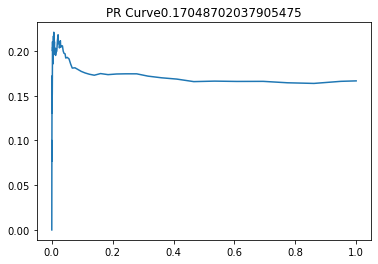

(3229,)
(19376,) (19376,)
AUC : 0.1655 


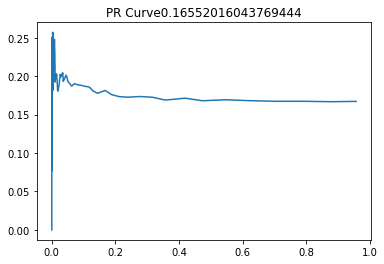

(3229,)
(19376,) (19376,)
AUC : 0.1611 


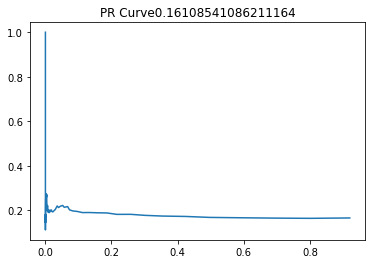

In [9]:
test(
    dagmm_obj,
    data_dict
)